In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# ---- USER CONFIG ----
csv_dir = "./data/analysis/results/"                    
top_k = 5                         # how many top gaps to show/plot
save_ranked_csv = "ranked_gaps.csv"
# ----------------------


all_csvs = glob.glob(os.path.join(csv_dir, "*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSVs found in {csv_dir}")
def pick_candidate(substr, files):
    cand = [f for f in files if substr.lower() in os.path.basename(f).lower()]
    if not cand:
        return None
    # return the most likely: if multiple, prefer the one with 'untargeted' or shortest name
    cand = sorted(cand, key=lambda x: (('untargeted' in x.lower()) == False, len(x)))
    return cand[0]
# locate the three types
f_routed = pick_candidate("advlogifold_routed", all_csvs)
f_comm = pick_candidate("logifold_committees_experts", all_csvs)
f_baseline = pick_candidate("baseline_single_models", all_csvs)

all_routed = [f for f in all_csvs if "advlogifold_routed" in os.path.basename(f).lower()]
all_comm = [f for f in all_csvs if "logifold_committees_experts" in os.path.basename(f).lower()]
all_baseline = [f for f in all_csvs if "baseline_single_models" in os.path.basename(f).lower()]

# Load
df_cand_routed = pd.read_csv(f_routed)
df_cand_comm = pd.read_csv(f_comm)
df_cand_base = pd.read_csv(f_baseline)

# Inspect columns (quick)
print("\nColumns (routed):", df_cand_routed.columns.tolist())
print("Columns (Not-routed):", df_cand_comm.columns.tolist())
print("Columns (baseline):", df_cand_base.columns.tolist())
print(all_routed)
print(all_comm)
print(all_baseline)


Columns (routed): ['testing_dataset', 'simple_majority_voting_by_all', 'weighted_voting_by_all', 'average_voting_by_all', 'using_val_history_by_all', 'entropy_threshold']
Columns (Not-routed): ['testing_dataset', 'simple_majority_voting_by_Judges', 'weighted_voting_by_Judges', 'average_voting_by_Judges', 'using_val_history_by_Judges', 'simple_majority_voting_by_all', 'weighted_voting_by_all', 'average_voting_by_all', 'using_val_history_by_all']
Columns (baseline): ['model', 'dataset', 'accuracy']
['./data/analysis/results/advlogifold_routed_experts-PGD_standard_targeted-to-least.csv', './data/analysis/results/advlogifold_routed_experts-PGD_bigstep_untargeted.csv', './data/analysis/results/advlogifold_routed_experts-FGM_untargeted.csv', './data/analysis/results/advlogifold_routed_experts-PGD_VGG_targeted-to-least.csv', './data/analysis/results/advlogifold_routed_experts-FGM_targeted-to-least.csv', './data/analysis/results/advlogifold_routed_experts-PGD_bigstep_targeted-to-least.csv', '

In [7]:
single_model_results = all_baseline[0]

df_single_model_results = pd.read_csv(single_model_results)
print(df_single_model_results)



                                                  model  \
0     ResNet56v1_union-of-original-and-cwl2-untarget...   
1     ResNet56v1_union-of-original-and-cwl2-untarget...   
2     ResNet56v1_union-of-original-and-deepfool-unta...   
3     ResNet56v1_union-of-original-and-deepfool-unta...   
4     ResNet56v1_union-of-original-and-fgm-eps216-ta...   
...                                                 ...   
2011                           resnet56v2_original_ver3   
2012                                vgg11_original_ver0   
2013                                vgg13_original_ver0   
2014                                vgg16_original_ver0   
2015                                vgg19_original_ver0   

                                                dataset  accuracy  
0          cwl2-targeted-to-2nd-by-resnet56v1-ver0_test    0.8344  
1          cwl2-targeted-to-2nd-by-resnet56v1-ver0_test    0.8428  
2          cwl2-targeted-to-2nd-by-resnet56v1-ver0_test    0.7883  
3          cwl2-tar

In [67]:
import re
def canonize_model(name: str) -> str:
    name = name.strip()
    name = name.lower()
    return re.sub(r"_ver\d+$", "", name)
df = df_single_model_results.copy()
df["canon_model"] = df["model"].map(canonize_model)

# 2) Average accuracy across versions for each (canon_model, dataset)
avg_df = (
    df.groupby(["canon_model", "dataset"], as_index=False)["accuracy"]
      .mean()
      .rename(columns={"accuracy": "avg_accuracy"})
)

# (Optional) Also get count of versions aggregated, for transparency
cnt_df = (
    df.groupby(["canon_model", "dataset"], as_index=False)["accuracy"]
      .size()
      .rename(columns={"size": "n_versions"})
)

avg_df = avg_df.merge(cnt_df, on=["canon_model", "dataset"], how="left")

# 3) If you need the single best averaged model per dataset:
best_per_dataset = (
    avg_df.sort_values(["dataset", "avg_accuracy"], ascending=[True, False])
          .groupby("dataset", as_index=False)
          .first()
)

# Show results
print("Averaged across versions (per canon_model, dataset):")
print(avg_df.sort_values(["dataset", "canon_model"]).to_string(index=False))

print("\nBest averaged single-model per dataset:")
print(best_per_dataset[["dataset", "canon_model", "avg_accuracy", "n_versions"]]
      .to_string(index=False))

Averaged across versions (per canon_model, dataset):
                                                                                                                                                                                     canon_model                                                            dataset  avg_accuracy  n_versions
                                                                                                                                                                             resnet20v1_original                       cwl2-targeted-to-2nd-by-resnet56v1-ver0_test      0.807588           8
                                                                                                                                                      resnet20v1_original_tuned-once-on_original                       cwl2-targeted-to-2nd-by-resnet56v1-ver0_test      0.889700           8
                                                                                         

In [68]:
def _gen_family(gen: str) -> str:
    g = gen.lower()
    if g.startswith("resnet"):
        return "resnet"
    if g.startswith("vgg"):
        return "vgg"
    return "other"
def _mode_token(mode: str) -> str:
    # map 'targeted-to-2nd'/'targeted-to-least'/'untargeted' -> ('2nd'|'least'|'')
    if "to-2nd" in mode:  return "2nd"
    if "to-least" in mode: return "least"
    if "untargeted" in mode: return ""
    return ""  # default

def _pgd_scale_from(name: str) -> str:
    # "eps216-iter96-8steps" -> 'big',  "eps8-iter2-10steps" -> 'std'
    if "eps216" in name: return "big"
    if "eps8"  in name: return "std"
    return ""



In [69]:
def simplify_testing_dataset(s: str) -> dict:
    """
    Returns dict with:
      attack: cwl2|pgd|fgm|deepfool|original
      mode: ''|'2nd'|'least'
      pgd_scale: ''|'big'|'std'
      generator: raw generator token (e.g., 'resnet56v1-ver0')
      generator_family: 'resnet'|'vgg'|'other'
      simple_label: your requested compact label
    """
    s = s.strip()
    if s == "original":
        return dict(attack="original", mode="", pgd_scale="", generator="",
                    generator_family="", simple_label="original")
    # Extract trailing generator "...-by-<GEN>-verX"
    gen = ""
    m_gen = re.search(r"-by-([a-zA-Z0-9]+(?:[a-zA-Z0-9]*))-(ver\d+)$", s)
    if m_gen:
        gen = f"{m_gen.group(1)}-{m_gen.group(2)}"
        genfam = _gen_family(m_gen.group(1))
    else:
        genfam = ""

    # Identify attack family
    if s.startswith("cwl2"):
        # cwl2-(targeted-to-2nd|targeted-to-least|untargeted)-by-...
        mode = _mode_token(s)
        if mode == "2nd":
            label = "cwl2(2nd)"
        elif mode == "least":
            label = "cwl2(least)"
        else:
            label = "cwl2"
        return dict(attack="cwl2", mode=mode, pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label=label)

    if s.startswith("deepfool"):
        # deepfool-untargeted-...
        return dict(attack="deepfool", mode="", pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label="DF")

    if s.startswith("fgm"):
        # fgm-eps216-(targeted-to-2nd|targeted-to-least|untargeted)-by-...
        mode = _mode_token(s)
        if mode == "2nd":
            label = "fgm(2nd)"
        elif mode == "least":
            label = "fgm(least)"
        else:
            label = "fgm"
        return dict(attack="fgm", mode=mode, pgd_scale="", generator=gen,
                    generator_family=genfam, simple_label=label)

    if s.startswith("pgd"):
        # pgd-<eps...>-<iter...>-<steps...>-(targeted-to-2nd|targeted-to-least|untargeted)-by-<GEN>-verX
        mode = _mode_token(s)
        scale = _pgd_scale_from(s)
        # Build label like pgd(least, big) or pgd(2nd, std) or pgd(big) for untargeted
        if mode:
            label = f"pgd({mode}, {scale})"
        else:
            label = f"pgd({scale})" if scale else "pgd"
        return dict(attack="pgd", mode=mode, pgd_scale=scale, generator=gen,
                    generator_family=genfam, simple_label=label)

    # Fallback
    return dict(attack="other", mode="", pgd_scale="", generator=gen,
                generator_family=genfam, simple_label=s)

In [70]:
def add_parsed_cols(df: pd.DataFrame, col="testing_dataset") -> pd.DataFrame:
    parsed = df[col].map(simplify_testing_dataset)
    # explode the dict into columns
    extra = pd.DataFrame(list(parsed))
    out = pd.concat([df.copy(), extra], axis=1)
    return out

In [71]:
def summarize_by_label_and_family(df: pd.DataFrame) -> pd.DataFrame:
    needed = [
        "simple_label", "generator_family",
        "Adv_using_history",
        "average_voting_by_Judges",
        "simple_majority_voting_by_Judges",
        'simple_majority_voting_by_all',
        'average_voting_by_all',
    ]
    
    avail = [c for c in needed if c in df.columns]
    agg = (df[avail]
           .groupby(["simple_label", "generator_family"], as_index=False)
           .mean(numeric_only=True))
    agg["Adv - judges_avg"] = agg["Adv_using_history"] - agg["average_voting_by_Judges"]
    agg["Adv - All_avg"] = agg["Adv_using_history"] - agg["average_voting_by_all"]
    agg["Adv - judges_majority"] = agg["Adv_using_history"] - agg["simple_majority_voting_by_Judges"]
    agg["Adv - All_majority"] = agg["Adv_using_history"] - agg["simple_majority_voting_by_all"]
    return agg

In [64]:
def summarize_by_label_overall(df: pd.DataFrame) -> pd.DataFrame:
    cols = [
        "simple_label",
        "Adv_using_history",
        "average_voting_by_Judges",
    ]
    agg = (df[cols]
           .groupby("simple_label", as_index=False)
           .mean(numeric_only=True))
    agg["gap_hist_minus_judges_avg"] = agg["Adv_using_history"] - agg["average_voting_by_Judges"]
    return agg

In [42]:
summarize_by_label_and_family(add_parsed_cols(df))

,simple_label,generator_family,using_val_history_by_all,average_voting_by_Judges,simple_majority_voting_by_Judges,simple_majority_voting_by_all,average_voting_by_all,Adv - judges_avg,Adv - All_avg,Adv - judges_majority,Adv - All_majority
0,DF,resnet,0.885100,0.889300,0.887500,0.888100,0.888800,-0.004200,-0.003700,-0.002400,-0.003000
1,cwl2,resnet,0.930900,0.934700,0.933600,0.934900,0.935500,-0.003800,-0.004600,-0.002700,-0.004000
2,cwl2(2nd),resnet,0.934600,0.934900,0.933600,0.934800,0.935400,-0.000300,-0.000800,0.001000,-0.000200
3,cwl2(least),resnet,0.938600,0.939400,0.938500,0.939100,0.938800,-0.000800,-0.000200,0.000100,-0.000500
4,fgm,resnet,0.700600,0.723200,0.721300,0.728000,0.727500,-0.022600,-0.026900,-0.020700,-0.027400
5,fgm(2nd),resnet,0.700900,0.726400,0.727400,0.731400,0.731900,-0.025500,-0.031000,-0.026500,-0.030500
6,fgm(least),resnet,0.700900,0.726400,0.727400,0.731400,0.731900,-0.025500,-0.031000,-0.026500,-0.030500
7,original,,0.937000,0.940800,0.940000,0.939800,0.939800,-0.003800,-0.002800,-0.003000,-0.002800
8,"pgd(2nd, big)",resnet,0.619800,0.595200,0.596700,0.609100,0.609300,0.024600,0.010500,0.023100,0.010700
9,"pgd(2nd, std)",resnet,0.936000,0.938800,0.938600,0.939000,0.939000,-0.002800,-0.003000,-0.002600,-0.003000


In [ ]:
def focal(focus: str = "Adv - judges_avg"):
    if focus not in ["Adv - judges_avg", "Adv - All_avg", "Adv - judges_majority", "Adv - All_majority"]:
        raise ValueError(f"focus must be one of 'Adv - judges_avg', 'Adv - All_avg', 'Adv - judges_majority', 'Adv - All_majority'")
    base_cols = ["simple_label", "generator_family", "Adv_using_history"]
    if focus == "Adv - judges_avg":
        return base_cols + ["average_voting_by_Judges", "Adv - judges_avg"]
    if focus == "Adv - All_avg":
        return base_cols + ["average_voting_by_all", "Adv - All_avg"]
    if focus == "Adv - judges_majority":
        return base_cols + ["simple_majority_voting_by_Judges", "Adv - judges_majority"]
    if focus == "Adv - All_majority":
        return base_cols + ["simple_majority_voting_by_all", "Adv - All_majority"]

In [ ]:
focus = "Adv - judges_avg"  
# or "Adv - All_avg" 
# or "Adv - judges_majority" 
# or "Adv - All_majority"

In [ ]:
# Example: pick PGD standard targeted-to-least
f_routed = "./data/analysis/results/advlogifold_routed_experts-PGD_standard_targeted-to-least.csv"
f_comm   = "./data/analysis/results/logifold_committees_experts-PGD_standard_targeted-to-least.csv"

df_routed = pd.read_csv(f_routed)
df_comm   = pd.read_csv(f_comm)

# 1. Grab the fixed entropy threshold
entropy_threshold = df_routed["entropy_threshold"].iloc[0]

# 2. Keep only the columns we care about
df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
cols = list(df_comm.columns)
cols.remove('using_val_history_by_all')
cols.remove('using_val_history_by_Judges')
df_comm_sel   = df_comm[cols].copy()  

# 3. Merge on dataset
df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", suffixes=("_routed", "_comm"))

# 4. Compute differences vs Judges (all four options)
for col in ["simple_majority_voting_by_Judges", 
            "weighted_voting_by_Judges", 
            "average_voting_by_Judges"]:
    df[f"diff_vs_{col}"] = df["using_val_history_by_all"] - df[col]

# 5. If multiple rows per testing_dataset exist, average them
df_avg = df.groupby("testing_dataset", as_index=False).mean(numeric_only=True)

# 6. Sort by the largest positive gap vs Judges’ simple average


print("Entropy threshold used:", entropy_threshold)


summary_df = summarize_by_label_and_family(add_parsed_cols(df))
summary_df_sorted = summary_df.sort_values(focus, ascending=False)
summary_df_sorted[focal(focus)]



Entropy threshold used: 79.61467792714079


,simple_label,generator_family,using_val_history_by_all,average_voting_by_Judges,Adv - judges_avg
8,"pgd(2nd, big)",resnet,0.619800,0.595200,0.024600
10,pgd(big),resnet,0.783125,0.771300,0.011825
11,pgd(big),vgg,0.869875,0.864875,0.005000
13,"pgd(least, big)",vgg,0.788500,0.785150,0.003350
12,"pgd(least, big)",resnet,0.790850,0.790325,0.000525
2,cwl2(2nd),resnet,0.934600,0.934900,-0.000300
3,cwl2(least),resnet,0.938600,0.939400,-0.000800
9,"pgd(2nd, std)",resnet,0.936000,0.938800,-0.002800
14,"pgd(least, std)",resnet,0.936700,0.940100,-0.003400
7,original,,0.937000,0.940800,-0.003800


In [ ]:
# map suffix key e.g. "PGD_standard_targeted-to-least"
def key_from_path(p: str, routed=True) -> str:
    base = os.path.basename(p)
    if routed:
        # advlogifold_routed_experts-<KEY>.csv
        m = re.match(r"advlogifold_routed_experts-(.+)\.csv$", base)
    else:
        # logifold_committees_experts-<KEY>.csv
        m = re.match(r"logifold_committees_experts-(.+)\.csv$", base)
    return m.group(1) if m else None




{'PGD_standard_untargeted': './data/analysis/results/logifold_committees_experts-PGD_standard_untargeted.csv',
 'PGD_VGG_targeted-to-least': './data/analysis/results/logifold_committees_experts-PGD_VGG_targeted-to-least.csv',
 'CWL2_untargeted': './data/analysis/results/logifold_committees_experts-CWL2_untargeted.csv',
 'FGM_untargeted': './data/analysis/results/logifold_committees_experts-FGM_untargeted.csv',
 'PGD_bigstep_untargeted': './data/analysis/results/logifold_committees_experts-PGD_bigstep_untargeted.csv',
 'FGM_targeted-to-least': './data/analysis/results/logifold_committees_experts-FGM_targeted-to-least.csv',
 'PGD_standard_targeted-to-2nd': './data/analysis/results/logifold_committees_experts-PGD_standard_targeted-to-2nd.csv',
 'PGD_standard_targeted-to-least': './data/analysis/results/logifold_committees_experts-PGD_standard_targeted-to-least.csv',
 'PGD_bigstep_targeted-to-least': './data/analysis/results/logifold_committees_experts-PGD_bigstep_targeted-to-least.csv',
 

In [ ]:

comm_index = { key_from_path(p, routed=False): p for p in all_comm }
# choose your focus metric to sort/print
all_results = []  # collect for one big dataframe

for f_routed in all_routed:
    key = key_from_path(f_routed, routed=True)
    f_comm = comm_index.get(key)
    if not key or not f_comm:
        # If no exact match, skip (keys differ like PGD_VGG vs PGD_standard, etc.)
        continue

    df_routed = pd.read_csv(f_routed)
    df_comm   = pd.read_csv(f_comm)
    cols = list(df_comm.columns)
    cols.remove('using_val_history_by_all')
    cols.remove('using_val_history_by_Judges')
    df_comm_sel   = df_comm[cols].copy()  
    # entropy (fixed in each routed file)
    entropy_threshold = df_routed["entropy_threshold"].iloc[0] if "entropy_threshold" in df_routed.columns else None

    # select & merge
    df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
    df_routed_sel = df_routed_sel.rename(columns={"using_val_history_by_all": "Adv_using_history"})
    df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", how="inner")

    df = add_parsed_cols(df)
    summary = summarize_by_label_and_family(df)

    

    # sort for display
    summary_sorted = summary.sort_values(focus, ascending=False, na_position="last")

    # ------- PRINT -------
    print(f"\n=== {key} ===")
    looking_at = ['simple_label', 
                    'generator_family', 
                    'Adv_using_history', 
                    #  'average_voting_by_Judges', 
                    #  'simple_majority_voting_by_Judges', 
                    #  'simple_majority_voting_by_all',
                    #  'average_voting_by_all', 
                    'Adv - judges_avg', 
                    'Adv - All_avg', 
                    'Adv - judges_majority', 
                    'Adv - All_majority']
    print(f"entropy_threshold = {entropy_threshold}")
    fmt = {c: "{:.3f}".format for c in ['Adv - judges_avg', 
                                        'Adv - All_avg', 
                                        'Adv - judges_majority', 
                                        'Adv - All_majority']}
    fmt.update({'Adv_using_history' : "{:.4f}".format})
    print(summary_sorted[looking_at].to_string(index=False,formatters=fmt))
    # keep key/threshold in the table
    summary.insert(0, "logifold_type", key)
    summary.insert(1, "entropy_threshold", entropy_threshold)
    all_results.append(summary)

# if all_results:
#     combined = pd.concat(all_results, ignore_index=True)
#     combined = combined.sort_values(["logifold_type", focus], ascending=[True, False])
    #     combined.to_csv("./all_logifold_summaries.csv", index=False)
    #     print("\nSaved: ./all_logifold_summaries.csv")


=== PGD_standard_targeted-to-least ===
entropy_threshold = 79.61467792714079
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.6198            0.025         0.011                 0.023              0.011
       pgd(big)           resnet            0.7831            0.012         0.006                 0.011              0.006
       pgd(big)              vgg            0.8699            0.005         0.004                 0.005              0.004
pgd(least, big)              vgg            0.7885            0.003        -0.001                 0.005              0.000
pgd(least, big)           resnet            0.7908            0.001        -0.007                 0.002             -0.007
      cwl2(2nd)           resnet            0.9346           -0.000        -0.001                 0.001             -0.000
    cwl2(least)           resnet            0.9386           

In [80]:
import matplotlib.pyplot as plt
def plot_table(summary_sorted, key, top_n=10, outdir="./plots"):
    os.makedirs(outdir, exist_ok=True)
    cols = ["simple_label", "generator_family", "Adv_using_history", "Adv - judges_avg"]
    tab = summary_sorted[cols].head(top_n).copy()
    tab["Adv_using_history"] = tab["Adv_using_history"].round(4)
    tab["Adv - judges_avg"] = tab["Adv - judges_avg"].round(3)
    tab.insert(0, "label", tab["simple_label"] + " \u2022 " + tab["generator_family"])
    tab = tab.drop(columns=["simple_label", "generator_family"])

    fig, ax = plt.subplots(figsize=(8, 0.4*len(tab) + 1))
    ax.axis("off")
    tbl = ax.table(cellText=tab.values,
                   colLabels=tab.columns,
                   loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.2)
    plt.title(f"Top {len(tab)} — {key}")
    # out_png = os.path.join(outdir, f"table_{re.sub(r'[^A-Za-z0-9_.-]+','_',key)}.png")
    # plt.savefig(out_png, dpi=200, bbox_inches="tight")
    # print(f"Saved plot: {out_png}")
    
    plt.show()
    plt.close()

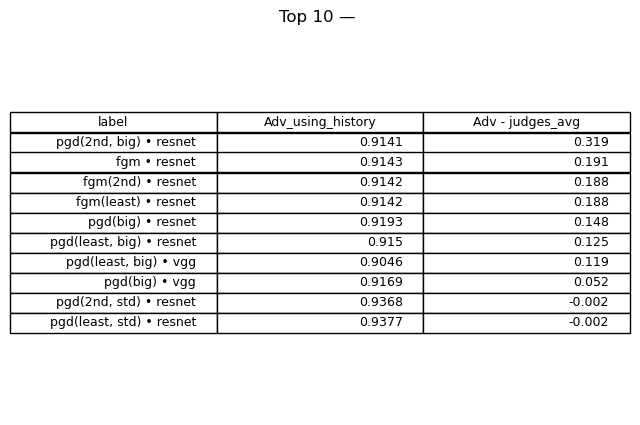

In [82]:
plot_table(summary_sorted, key = '')

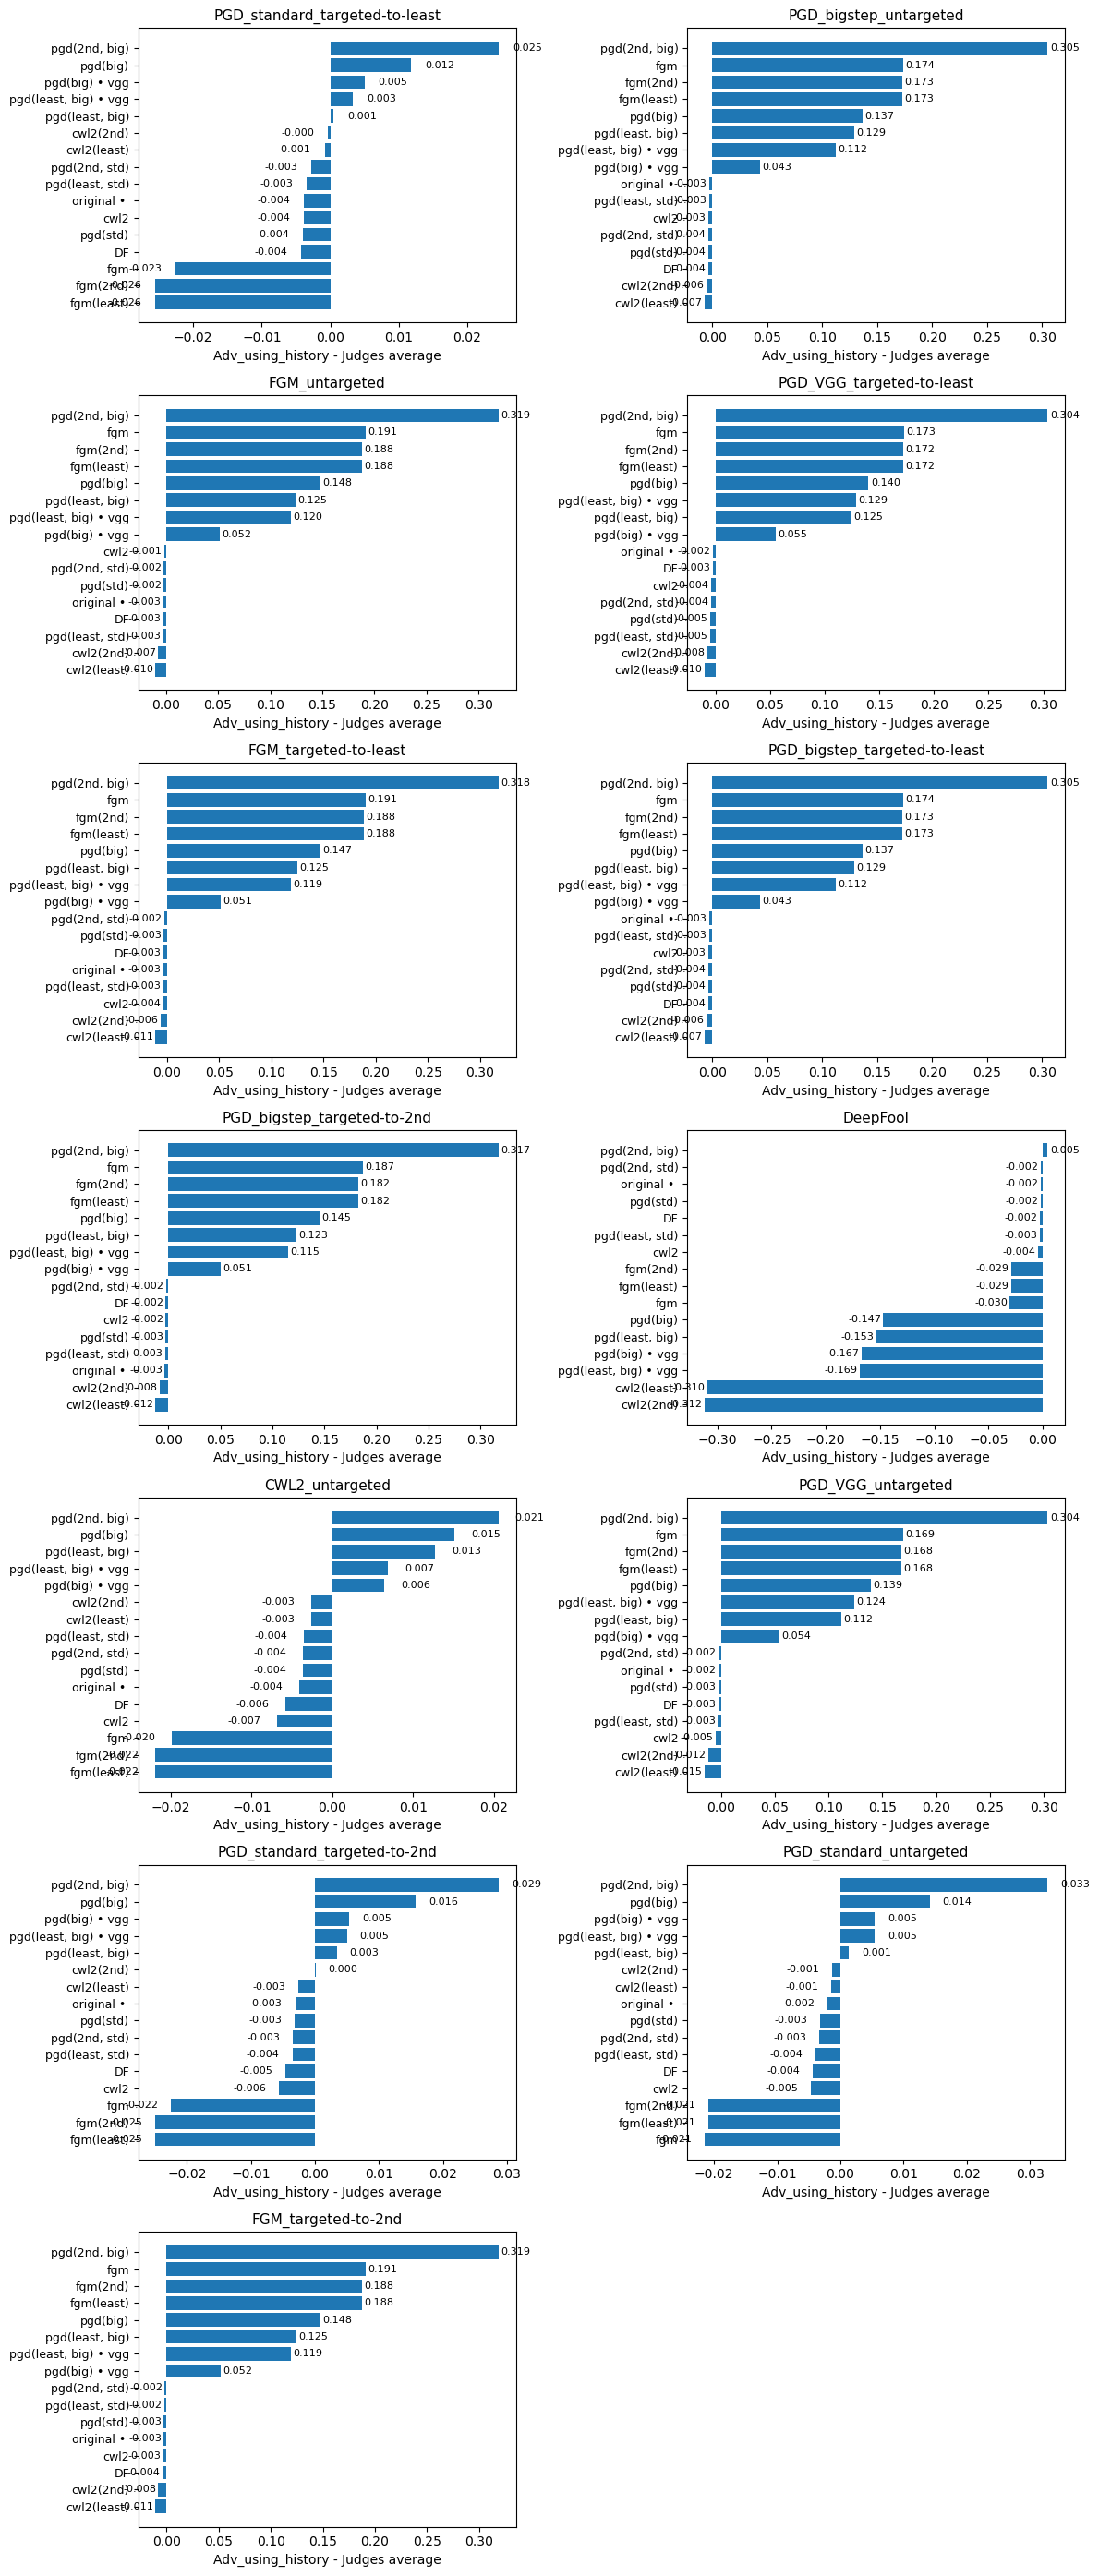

In [ ]:
combined = pd.concat(all_results, ignore_index=True)
focus = "Adv - judges_avg"
types = combined["logifold_type"].unique().tolist()
cols = 2
rows = int(np.ceil(len(types) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.ravel()

for ax, key in zip(axes, types):
    sub = combined[combined["logifold_type"] == key] \
                 .sort_values(focus, ascending=False) 
    labels = np.where(
                    sub["generator_family"] == "resnet",
                    sub["simple_label"],
                    sub["simple_label"] + " \u2022 " + sub["generator_family"]
                ).tolist()
    vals = sub[focus].values
    y = np.arange(len(vals))
    ax.barh(y, vals)
    ax.invert_yaxis()
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel("Adv_using_history - Judges average")
    ax.set_title(key, fontsize=11)
    for i, v in enumerate(vals):
        ax.text(v + (0.002 if v >= 0 else -0.002),
                i, f"{v:.3f}", va="center",
                ha="left" if v >= 0 else "right", fontsize=8)

# hide any extra axes
for j in range(len(types), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
# plt.savefig("./plots/gaps_small_multiples.png", dpi=200)
# print("Saved plot: ./plots/gaps_small_multiples.png")
plt.show()


In [94]:
import os, re, numpy as np, matplotlib.pyplot as plt

FOCUS_COLS = ["Adv - judges_avg", "Adv - All_avg"]  # add more if you want

def plot_grouped_gaps(summary_sorted, key, top_n=10, outdir="./plots"):
    os.makedirs(outdir, exist_ok=True)

    sub = summary_sorted.copy()

    # ----- labels (conditional family suffix) -----
    labels = np.where(
        sub["generator_family"] == "resnet",
        sub["simple_label"],
        sub["simple_label"] + " \u2022 " + sub["generator_family"]
    ).tolist()

    # ----- values matrix (N x M) for grouped bars -----
    vals = sub[FOCUS_COLS].values  # shape: (N, 2)
    N, M = vals.shape

    # ----- bar positions -----
    y = np.arange(N)
    bar_gap = 0.35           # thickness of each bar group lane
    bar_height = bar_gap / M # height of each bar in the group
    offsets = (np.arange(M) - (M-1)/2.0) * (bar_height * 1.2)  # small spacing between the grouped bars

    # ----- plot -----
    plt.figure(figsize=(10, max(4, 0.5*N + 1)))
    for j in range(M):
        bj = plt.barh(y + offsets[j], vals[:, j], height=bar_height, label=FOCUS_COLS[j])
        # annotate values at the RIGHT of each bar
        for i, rect in enumerate(bj):
            v = vals[i, j]
            x = rect.get_width()
            yy = rect.get_y() + rect.get_height()/2
            # pad slightly to the right (or left if negative)
            pad = 0.002 if v >= 0 else -0.002
            ha = "left" if v >= 0 else "right"
            plt.text(x + pad, yy, f"{v:.3f}", va="center", ha=ha, fontsize=9, clip_on=False)

    plt.yticks(y, labels)
    plt.xlabel("Gap vs. committee baselines")
    plt.title(f"Gaps by dataset label — {key}")
    plt.axvline(0, linewidth=0.8)  # zero line for reference
    plt.legend(title="Metric", loc="best")
    plt.tight_layout()

    safe_key = re.sub(r"[^A-Za-z0-9_.-]+", "_", key)
    out_png = os.path.join(outdir, f"gaps_grouped_{safe_key}.png")
    plt.savefig(out_png, dpi=200)
    print(f"Saved plot: {out_png}")
    plt.show()
    plt.close()
    
    

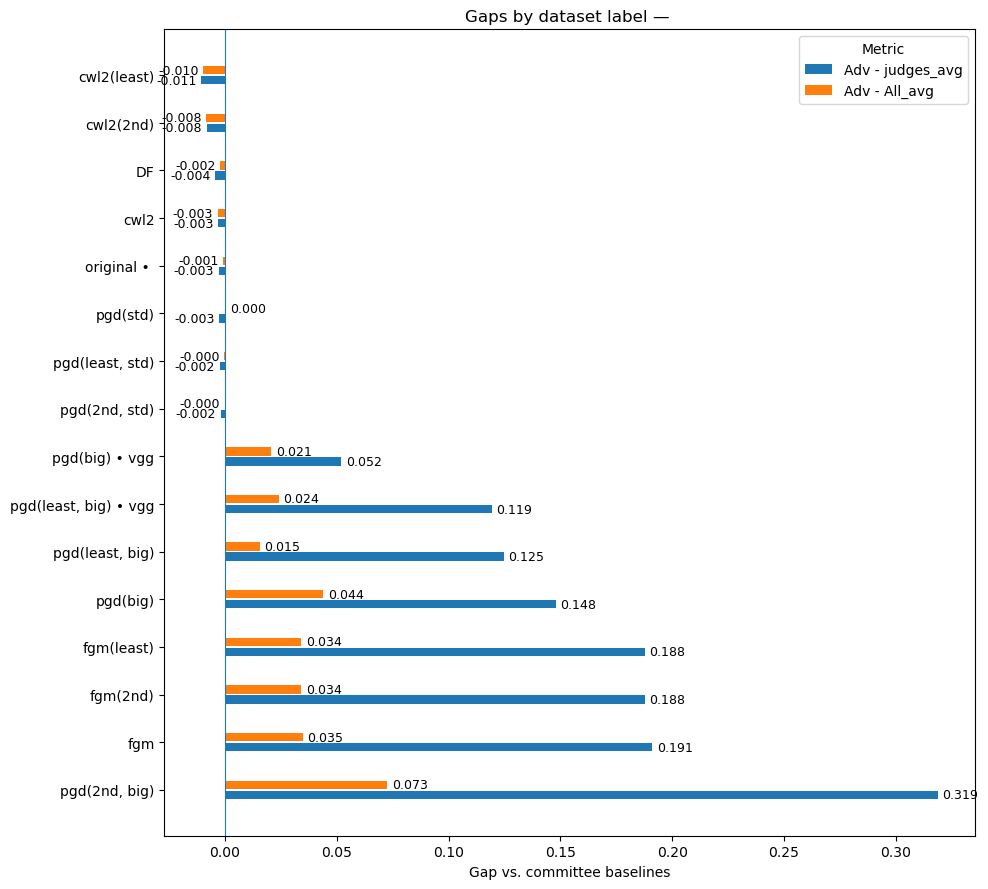

In [ ]:
plot_grouped_gaps(summary_sorted, '')


=== PGD_standard_targeted-to-least ===
entropy_threshold = 79.61467792714079
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.6198            0.025         0.011                 0.023              0.011
       pgd(big)           resnet            0.7831            0.012         0.006                 0.011              0.006
       pgd(big)              vgg            0.8699            0.005         0.004                 0.005              0.004
pgd(least, big)              vgg            0.7885            0.003        -0.001                 0.005              0.000
pgd(least, big)           resnet            0.7908            0.001        -0.007                 0.002             -0.007
      cwl2(2nd)           resnet            0.9346           -0.000        -0.001                 0.001             -0.000
    cwl2(least)           resnet            0.9386           

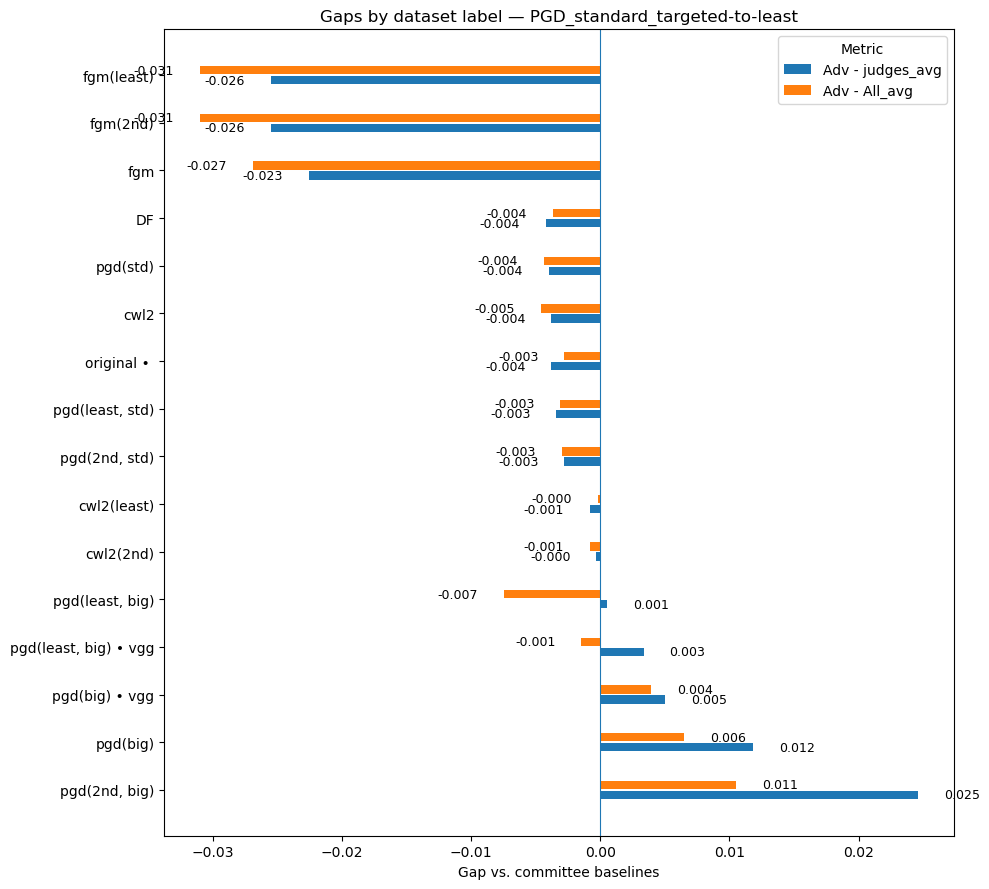


=== PGD_bigstep_untargeted ===
entropy_threshold = 153.61881936525455
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9003            0.305         0.087                 0.304              0.089
            fgm           resnet            0.8968            0.174         0.045                 0.175              0.047
       fgm(2nd)           resnet            0.8992            0.173         0.045                 0.172              0.049
     fgm(least)           resnet            0.8992            0.173         0.045                 0.172              0.049
       pgd(big)           resnet            0.9082            0.137         0.046                 0.136              0.047
pgd(least, big)           resnet            0.9195            0.129         0.018                 0.131              0.021
pgd(least, big)              vgg            0.8974            0.112 

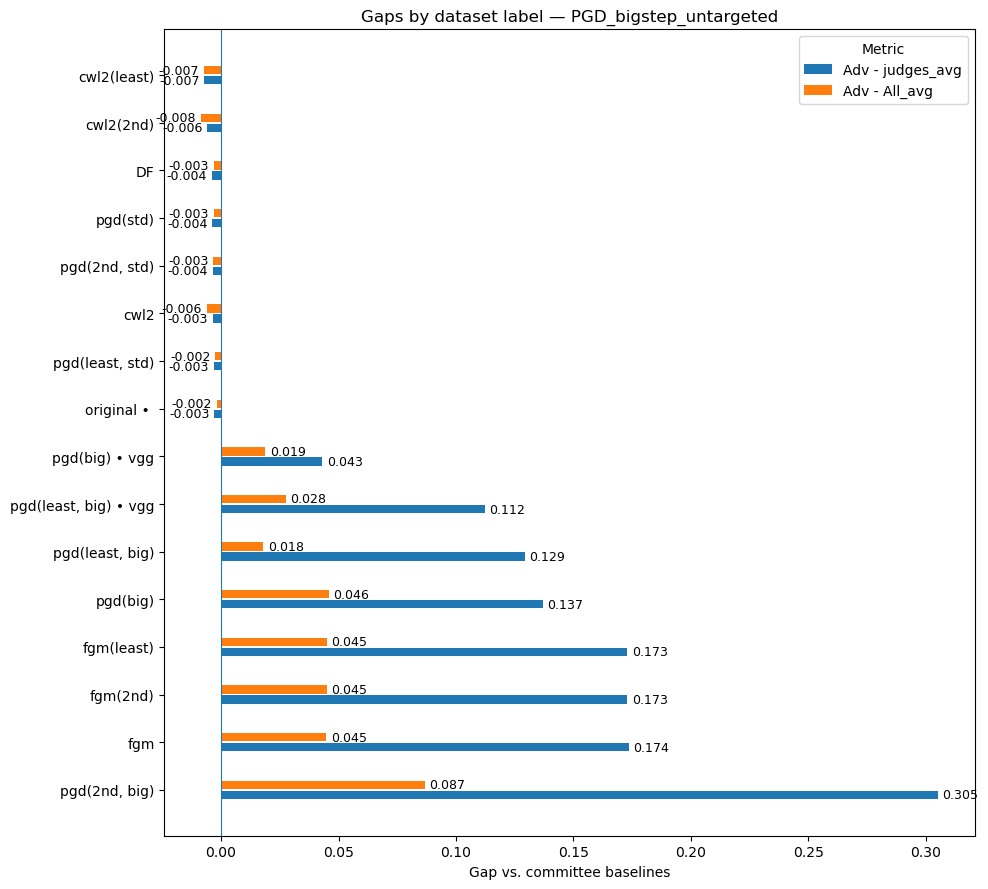


=== FGM_untargeted ===
entropy_threshold = 149.7547331019959
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9143            0.319         0.072                 0.318              0.076
            fgm           resnet            0.9144            0.191         0.036                 0.193              0.040
       fgm(2nd)           resnet            0.9147            0.188         0.035                 0.187              0.041
     fgm(least)           resnet            0.9147            0.188         0.035                 0.187              0.041
       pgd(big)           resnet            0.9194            0.148         0.044                 0.147              0.046
pgd(least, big)           resnet            0.9150            0.125         0.016                 0.126              0.019
pgd(least, big)              vgg            0.9051            0.120         0

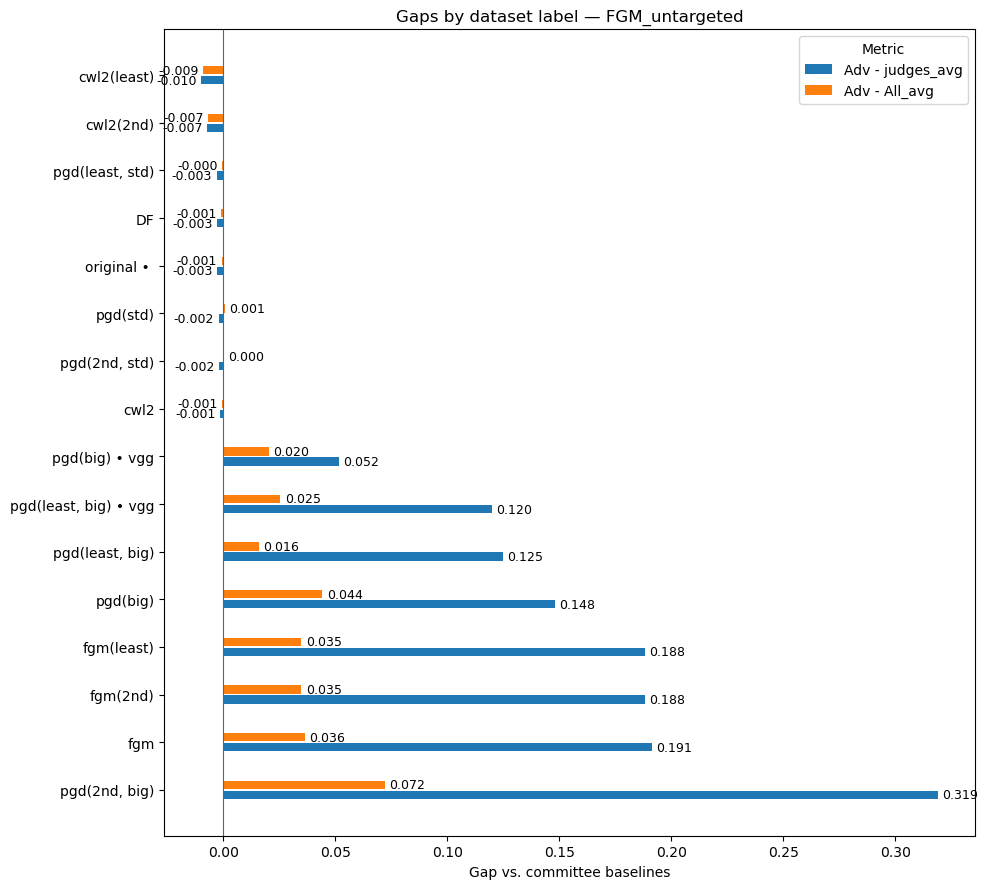


=== PGD_VGG_targeted-to-least ===
entropy_threshold = 143.21193691002415
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.8993            0.304         0.083                 0.303              0.086
            fgm           resnet            0.8957            0.173         0.041                 0.174              0.044
       fgm(2nd)           resnet            0.8984            0.172         0.043                 0.171              0.045
     fgm(least)           resnet            0.8984            0.172         0.043                 0.171              0.045
       pgd(big)           resnet            0.9114            0.140         0.045                 0.139              0.046
pgd(least, big)              vgg            0.9139            0.129         0.025                 0.130              0.028
pgd(least, big)           resnet            0.9148            0.1

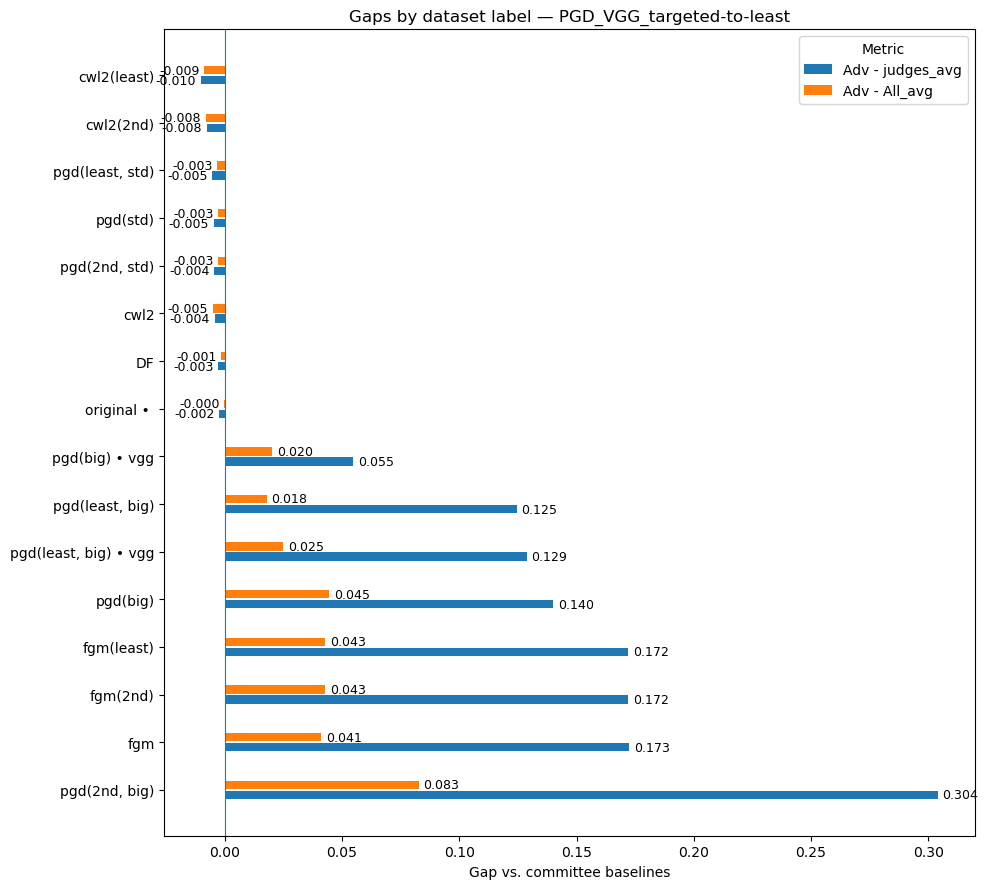


=== FGM_targeted-to-least ===
entropy_threshold = 147.8986078555462
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9130            0.318         0.073                 0.316              0.077
            fgm           resnet            0.9138            0.191         0.035                 0.192              0.039
       fgm(2nd)           resnet            0.9148            0.188         0.035                 0.187              0.041
     fgm(least)           resnet            0.9148            0.188         0.035                 0.187              0.041
       pgd(big)           resnet            0.9184            0.147         0.044                 0.146              0.045
pgd(least, big)           resnet            0.9152            0.125         0.016                 0.126              0.017
pgd(least, big)              vgg            0.9041            0.119   

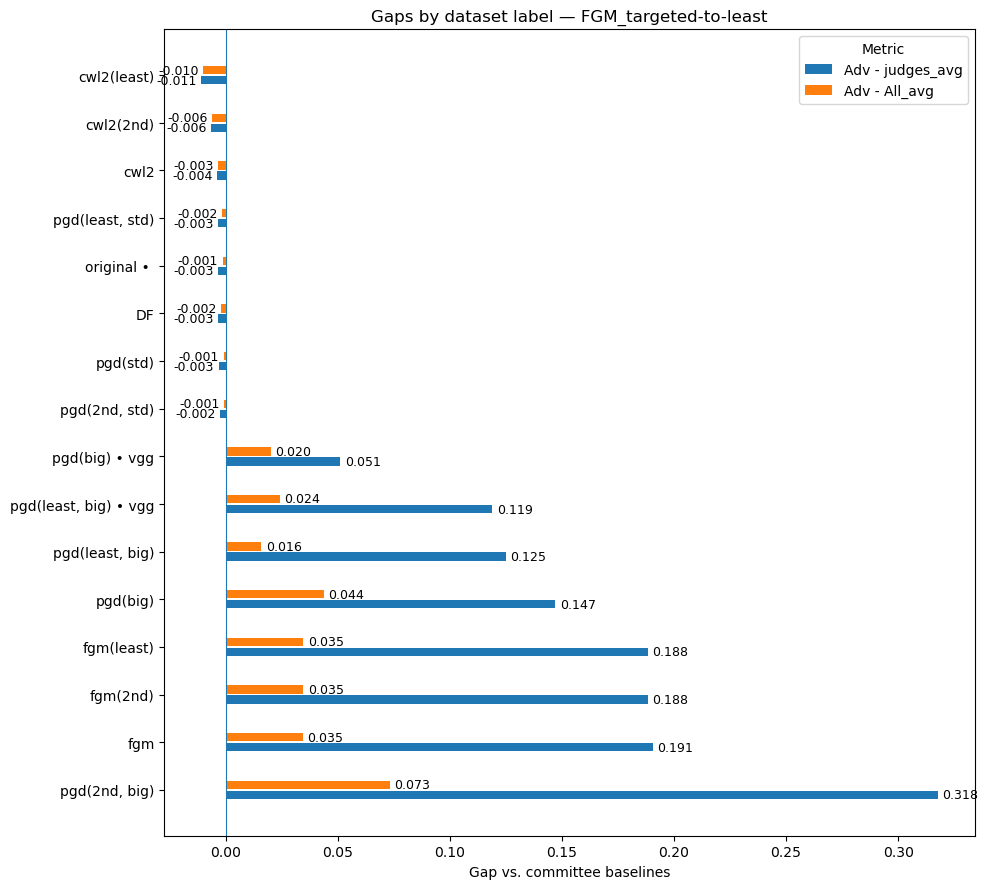


=== PGD_bigstep_targeted-to-least ===
entropy_threshold = 153.61881936525455
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9003            0.305         0.087                 0.304              0.089
            fgm           resnet            0.8968            0.174         0.045                 0.175              0.047
       fgm(2nd)           resnet            0.8992            0.173         0.045                 0.172              0.049
     fgm(least)           resnet            0.8992            0.173         0.045                 0.172              0.049
       pgd(big)           resnet            0.9082            0.137         0.046                 0.136              0.047
pgd(least, big)           resnet            0.9195            0.129         0.018                 0.131              0.021
pgd(least, big)              vgg            0.8974           

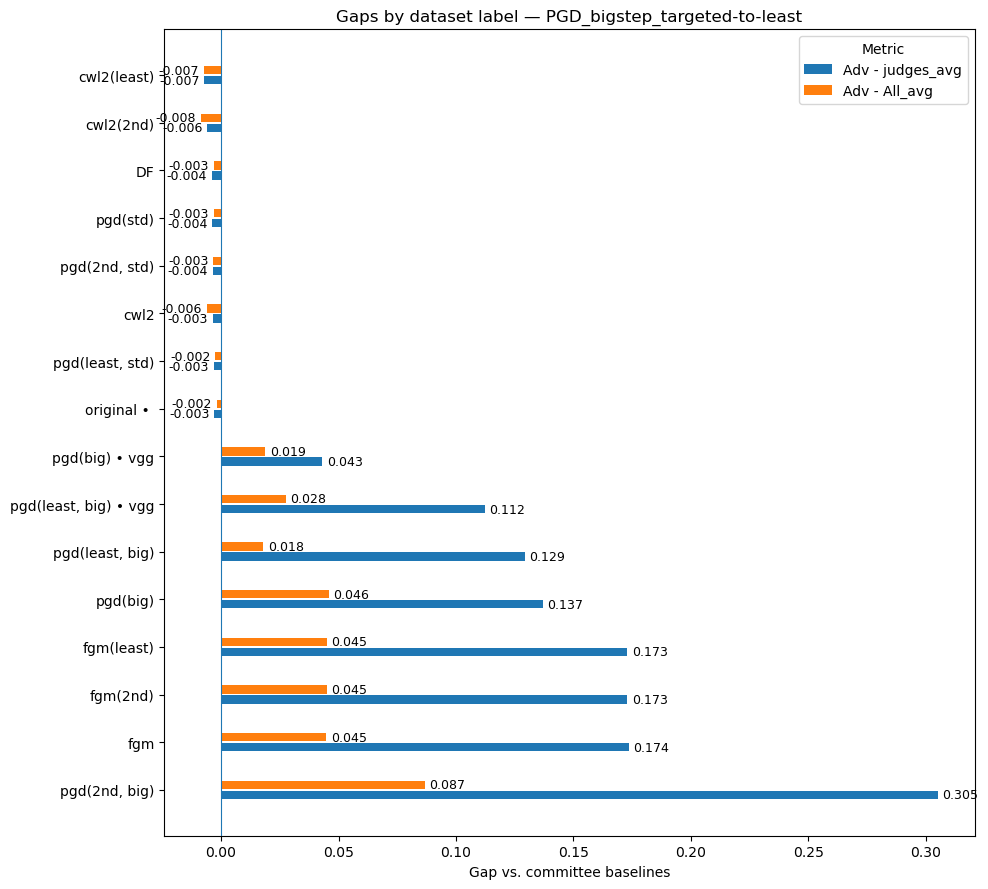


=== PGD_bigstep_targeted-to-2nd ===
entropy_threshold = 157.30536953819913
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9126            0.317         0.070                 0.316              0.075
            fgm           resnet            0.9099            0.187         0.038                 0.189              0.041
       fgm(2nd)           resnet            0.9089            0.182         0.036                 0.181              0.040
     fgm(least)           resnet            0.9089            0.182         0.036                 0.181              0.040
       pgd(big)           resnet            0.9168            0.145         0.042                 0.145              0.043
pgd(least, big)           resnet            0.9136            0.123         0.017                 0.125              0.019
pgd(least, big)              vgg            0.9005            0

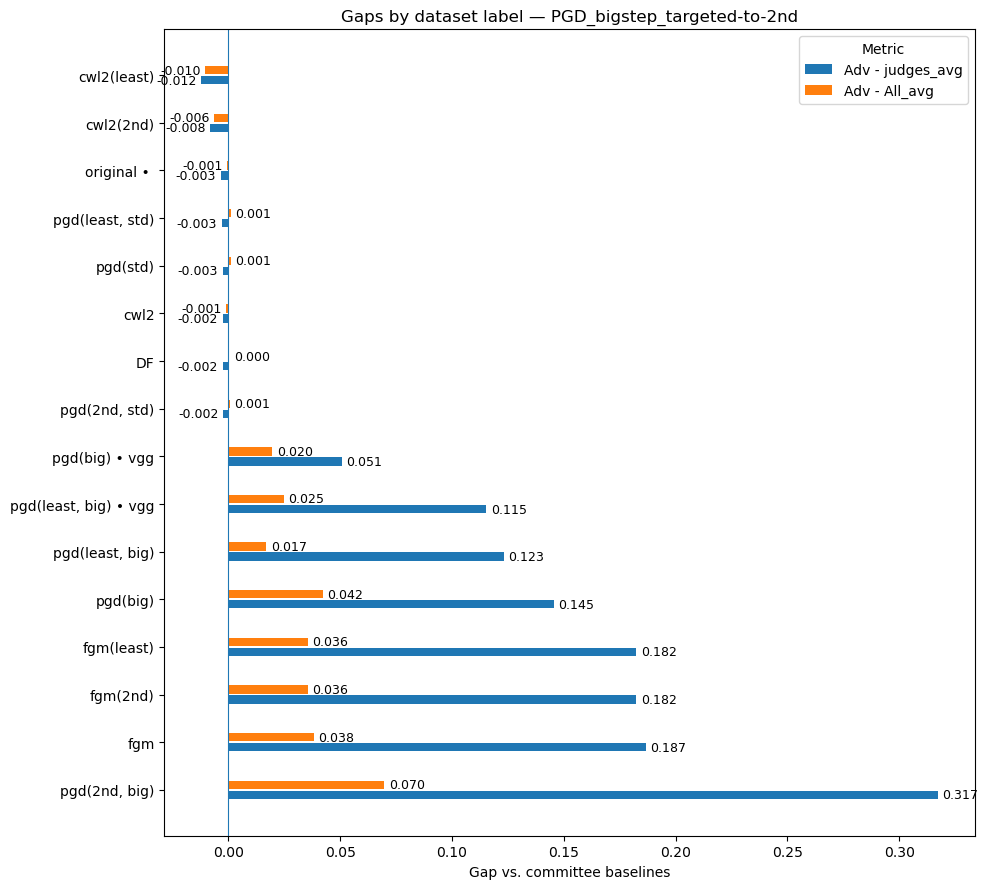


=== DeepFool ===
entropy_threshold = 110.45116086040606
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.5998            0.005        -0.045                 0.003             -0.049
  pgd(2nd, std)           resnet            0.9371           -0.002         0.004                -0.001              0.008
       original                             0.9388           -0.002         0.005                -0.001              0.009
       pgd(std)           resnet            0.9373           -0.002         0.004                -0.001              0.009
             DF           resnet            0.8869           -0.002        -0.006                -0.001             -0.003
pgd(least, std)           resnet            0.9376           -0.003         0.004                -0.001              0.010
           cwl2           resnet            0.9304           -0.004         0.002 

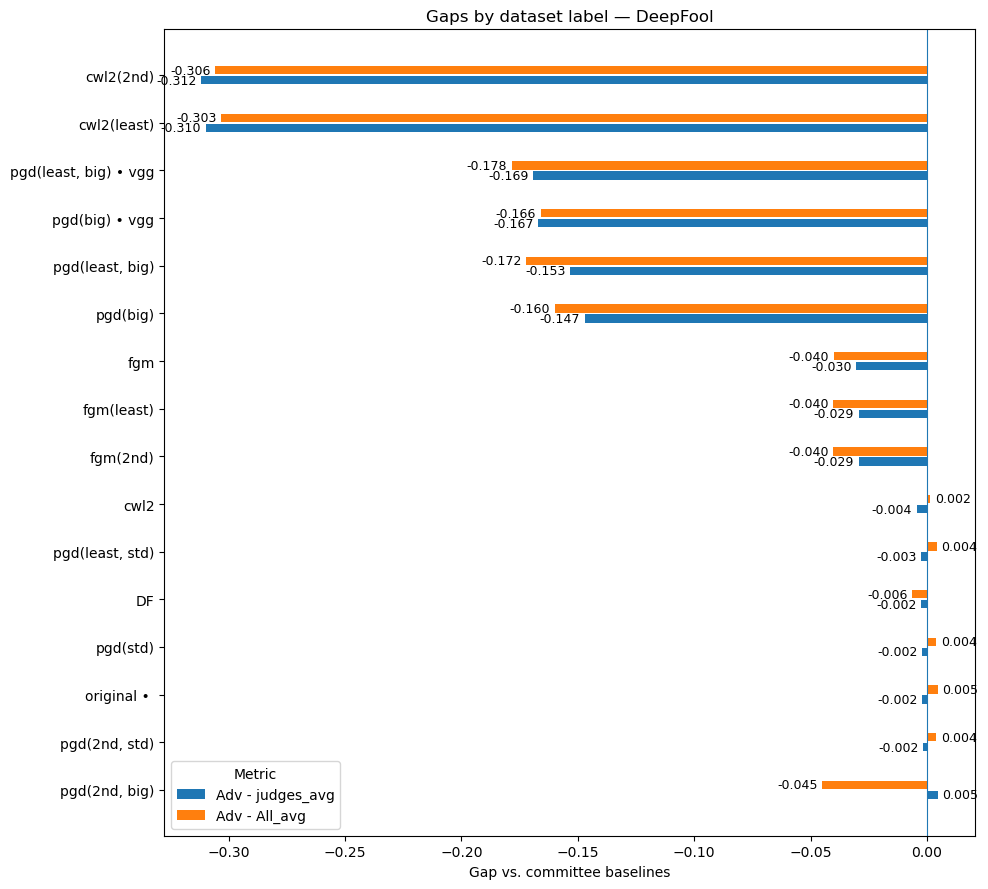


=== CWL2_untargeted ===
entropy_threshold = 86.0138557302856
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.6158            0.021         0.006                 0.019              0.003
       pgd(big)           resnet            0.7864            0.015         0.007                 0.014              0.007
pgd(least, big)           resnet            0.8031            0.013        -0.002                 0.014             -0.000
pgd(least, big)              vgg            0.7921            0.007        -0.001                 0.009              0.000
       pgd(big)              vgg            0.8713            0.006         0.004                 0.007              0.004
      cwl2(2nd)           resnet            0.9323           -0.003        -0.002                -0.001             -0.002
    cwl2(least)           resnet            0.9368           -0.003        -0

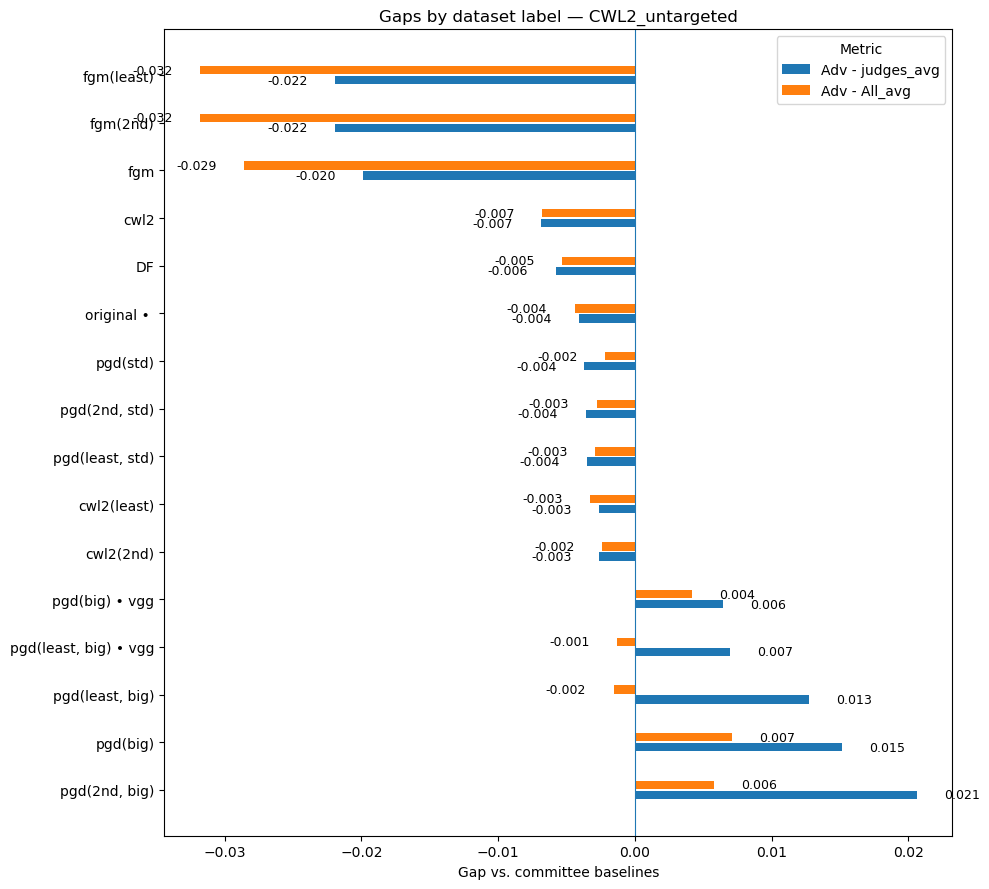


=== PGD_VGG_untargeted ===
entropy_threshold = 63.06013327552098
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.8988            0.304         0.076                 0.302              0.078
            fgm           resnet            0.8926            0.169         0.040                 0.171              0.041
       fgm(2nd)           resnet            0.8942            0.168         0.040                 0.167              0.042
     fgm(least)           resnet            0.8942            0.168         0.040                 0.167              0.042
       pgd(big)           resnet            0.9107            0.139         0.041                 0.139              0.042
pgd(least, big)              vgg            0.9087            0.124         0.023                 0.125              0.025
pgd(least, big)           resnet            0.9022            0.112      

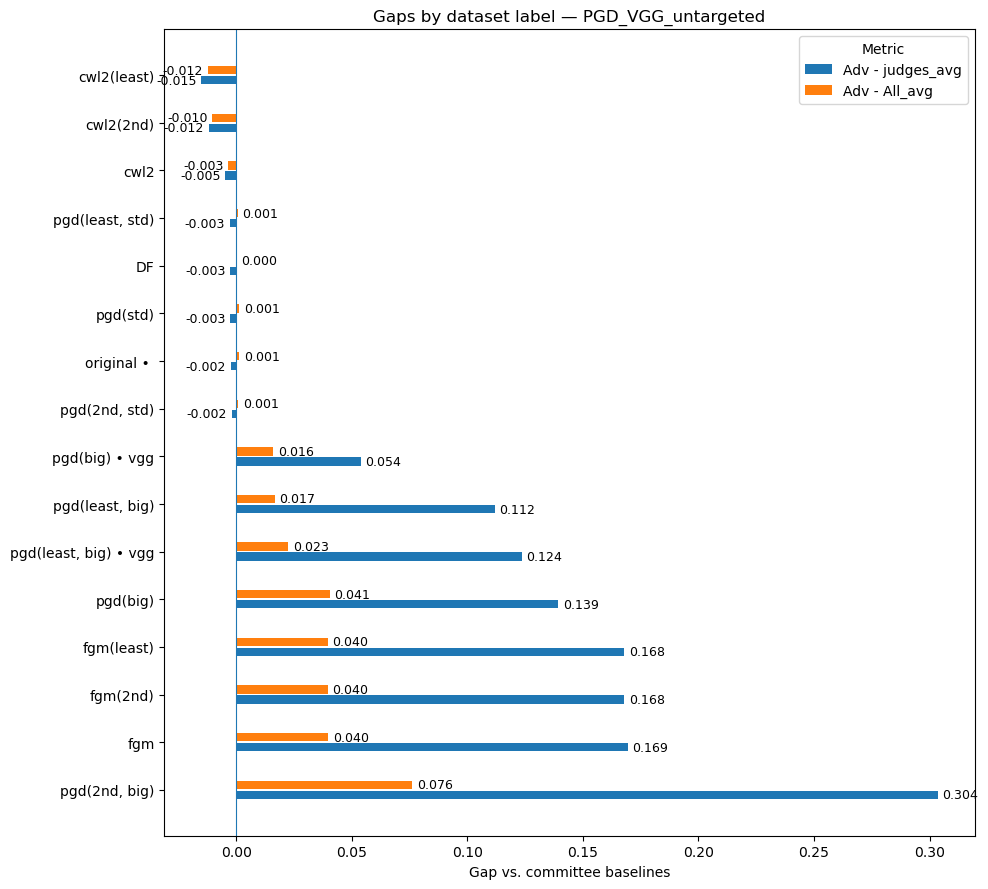


=== PGD_standard_targeted-to-2nd ===
entropy_threshold = 79.63245228229884
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.6239            0.029         0.014                 0.027              0.012
       pgd(big)           resnet            0.7871            0.016         0.009                 0.015              0.009
       pgd(big)              vgg            0.8703            0.005         0.004                 0.006              0.004
pgd(least, big)              vgg            0.7901            0.005        -0.002                 0.007             -0.000
pgd(least, big)           resnet            0.7937            0.003        -0.007                 0.005             -0.005
      cwl2(2nd)           resnet            0.9350            0.000        -0.001                 0.001              0.000
    cwl2(least)           resnet            0.9368           -0

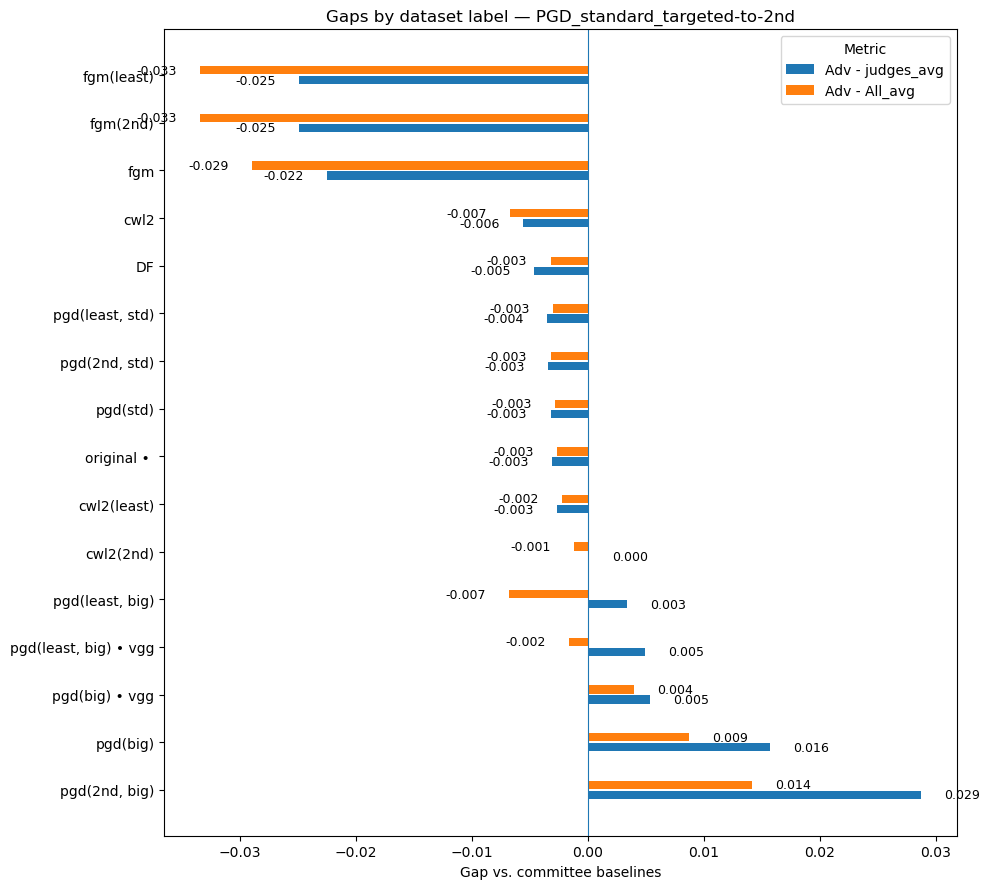


=== PGD_standard_untargeted ===
entropy_threshold = 79.81709946091024
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.6280            0.033         0.017                 0.031              0.017
       pgd(big)           resnet            0.7854            0.014         0.007                 0.013              0.007
       pgd(big)              vgg            0.8704            0.005         0.004                 0.006              0.005
pgd(least, big)              vgg            0.7906            0.005         0.000                 0.007              0.002
pgd(least, big)           resnet            0.7917            0.001        -0.008                 0.003             -0.006
      cwl2(2nd)           resnet            0.9336           -0.001        -0.002                 0.000             -0.001
    cwl2(least)           resnet            0.9380           -0.001 

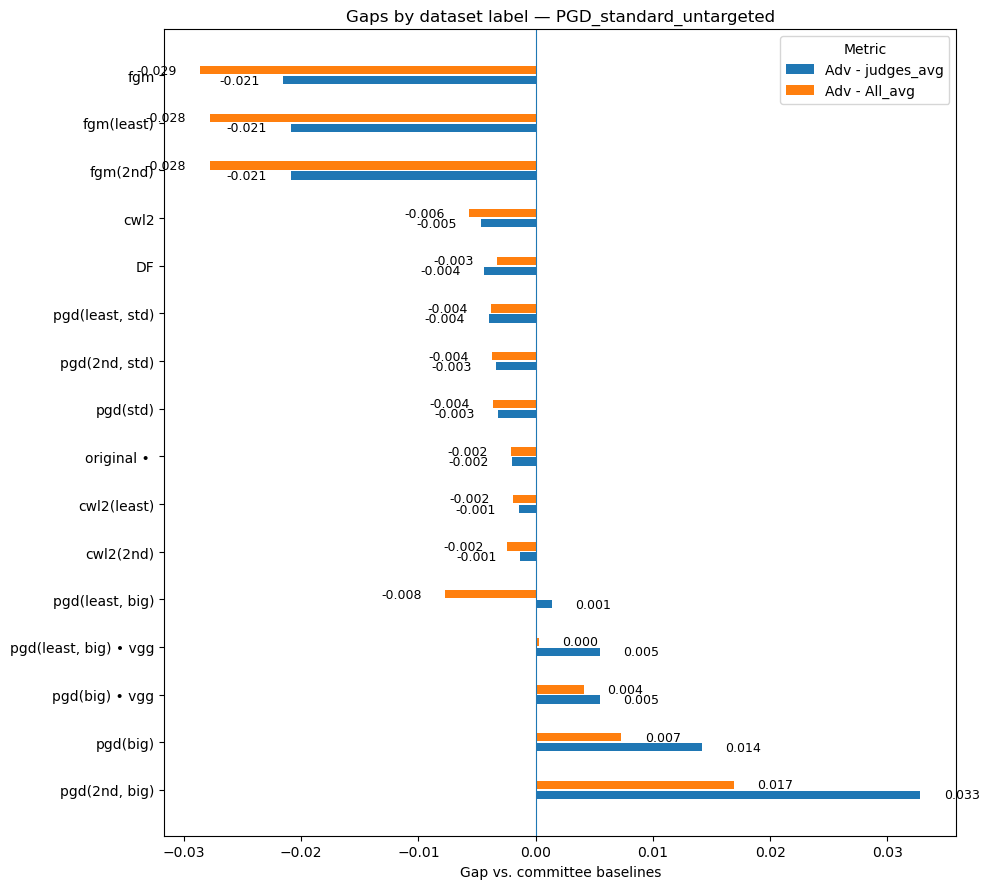


=== FGM_targeted-to-2nd ===
entropy_threshold = 147.8986078555462
   simple_label generator_family Adv_using_history Adv - judges_avg Adv - All_avg Adv - judges_majority Adv - All_majority
  pgd(2nd, big)           resnet            0.9141            0.319         0.073                 0.317              0.077
            fgm           resnet            0.9143            0.191         0.035                 0.193              0.038
       fgm(2nd)           resnet            0.9142            0.188         0.034                 0.187              0.039
     fgm(least)           resnet            0.9142            0.188         0.034                 0.187              0.039
       pgd(big)           resnet            0.9193            0.148         0.044                 0.147              0.046
pgd(least, big)           resnet            0.9150            0.125         0.015                 0.126              0.018
pgd(least, big)              vgg            0.9046            0.119     

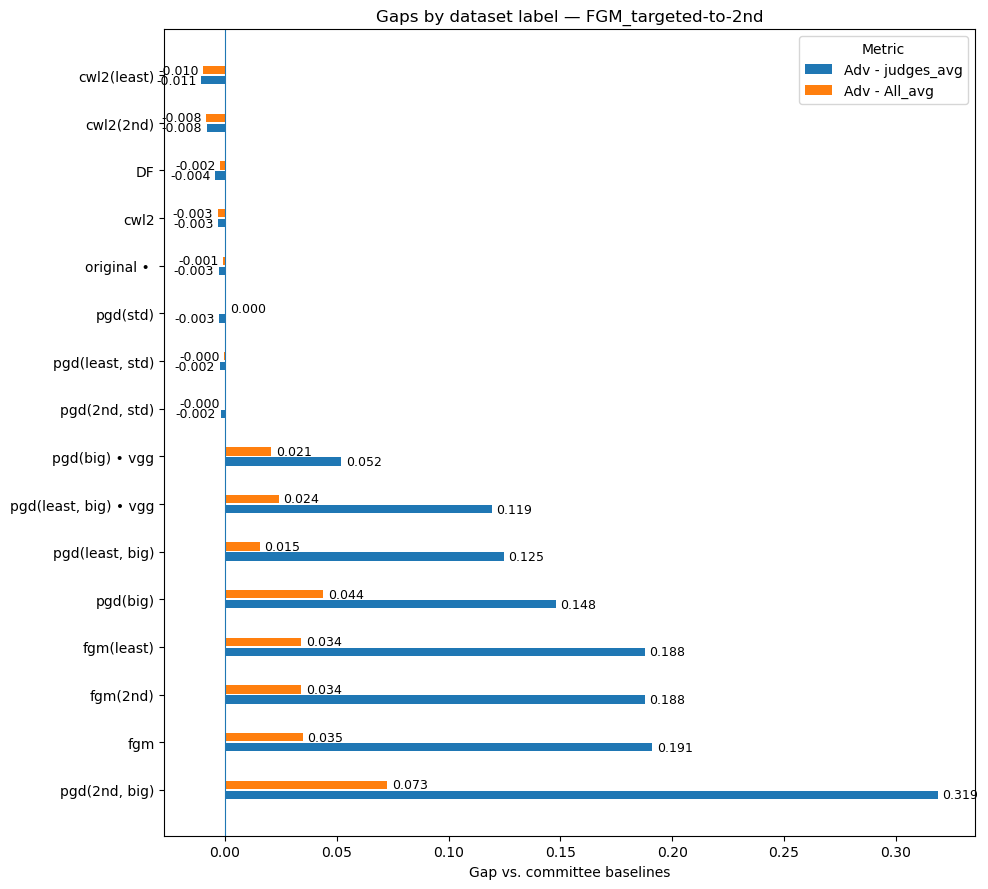


Saved: ./data/analysis/results/all_logifold_summaries.csv


In [ ]:

comm_index = { key_from_path(p, routed=False): p for p in all_comm }
# choose your focus metric to sort/print
all_results = []  # collect for one big dataframe

for f_routed in all_routed:
    key = key_from_path(f_routed, routed=True)
    f_comm = comm_index.get(key)
    if not key or not f_comm:
        # If no exact match, skip (keys differ like PGD_VGG vs PGD_standard, etc.)
        continue

    df_routed = pd.read_csv(f_routed)
    df_comm   = pd.read_csv(f_comm)
    cols = list(df_comm.columns)
    cols.remove('using_val_history_by_all')
    cols.remove('using_val_history_by_Judges')
    df_comm_sel   = df_comm[cols].copy()  
    # entropy (fixed in each routed file)
    entropy_threshold = df_routed["entropy_threshold"].iloc[0] if "entropy_threshold" in df_routed.columns else None

    # select & merge
    df_routed_sel = df_routed[["testing_dataset", "using_val_history_by_all"]].copy()
    df_routed_sel = df_routed_sel.rename(columns={"using_val_history_by_all": "Adv_using_history"})
    df = pd.merge(df_routed_sel, df_comm_sel, on="testing_dataset", how="inner")

    df = add_parsed_cols(df)
    summary = summarize_by_label_and_family(df)

    

    # sort for display
    summary_sorted = summary.sort_values(focus, ascending=False, na_position="last")

    # ------- PRINT -------
    print(f"\n=== {key} ===")
    looking_at = ['simple_label', 
                    'generator_family', 
                    'Adv_using_history', 
                    #  'average_voting_by_Judges', 
                    #  'simple_majority_voting_by_Judges', 
                    #  'simple_majority_voting_by_all',
                    #  'average_voting_by_all', 
                    'Adv - judges_avg', 
                    'Adv - All_avg', 
                    'Adv - judges_majority', 
                    'Adv - All_majority']
    print(f"entropy_threshold = {entropy_threshold}")
    fmt = {c: "{:.3f}".format for c in ['Adv - judges_avg', 
                                        'Adv - All_avg', 
                                        'Adv - judges_majority', 
                                        'Adv - All_majority']}
    fmt.update({'Adv_using_history' : "{:.4f}".format})
    print(summary_sorted[looking_at].to_string(index=False,formatters=fmt))
    # keep key/threshold in the table
    plot_grouped_gaps(summary_sorted, key)
    summary.insert(0, "logifold_type", key)
    summary.insert(1, "entropy_threshold", entropy_threshold)
    all_results.append(summary)
    
if all_results:
    combined = pd.concat(all_results, ignore_index=True)
    combined = combined.sort_values(["logifold_type", focus], ascending=[True, False])
    combined.to_csv("./data/analysis/results/all_logifold_summaries.csv", index=False)
    print("\nSaved: ./data/analysis/results/all_logifold_summaries.csv")

resnet20v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-pgd-eps8-iter2-10steps-untargeted-gen-by-resnet56v1-ver0_ver0.history.json


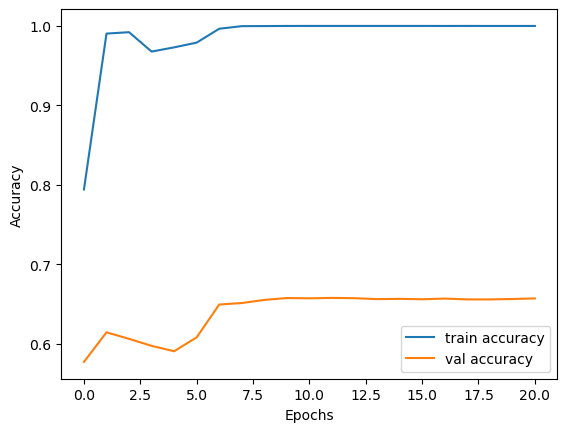

In [ ]:
import json
from pathlib import Path
specialized_model_paths = ['resnet20v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-pgd-eps8-iter2-10steps-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
        # 'resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_high-entropy-union-of-original-and-cwl2-untargeted-gen-by-resnet56v1-ver0_ver0.history.json',
    # 'resnet20v2_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver6_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver7_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver1_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver0_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver4_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v1_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet56v2_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver2_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v2_original_tuned-once-on_original_ver3_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json', 
# 'resnet20v1_original_tuned-once-on_original_ver5_specialized-once-on_high-entropy-union-of-original-and-deepfool-untargeted-gen-by-resnet56v1-ver0_ver0.history.json'
]
for path in specialized_model_paths:
    print(path)
    # fp = Path(path)
    # name = fp.stem
    # name = str(name.split("_")[0])
    with open('./data/specialized_models/'+ path, "r") as f:
        obj = json.load(f)
    hist = obj.get("history", obj)
    plt.plot(hist['accuracy'], label='train accuracy')
    plt.plot(hist['val_accuracy'], label='val accuracy')
    # plt.title(f'Accuracy of Adversarially trained ResNet56v1 (tuned once)\non {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()